In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import PIL.Image
import os
import seaborn as sbn
from albumentations import GaussNoise, RandomGridShuffle, Normalize, PixelDropout

sbn.set()

from google.colab import drive
drive.mount('/content/drive')

datadir = "/content/drive/MyDrive/Colab Notebooks/datasets/aia/EM_ISBI_Challenge/"

Mounted at /content/drive


In [45]:
# Make dataset class.
class ChallengeData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, train_set, margin_size=20):
        self.images = []
        self.labels = []

        self.train_set = train_set
  
        normalizer = Normalize(mean=(0.5), std=(0.5))

        img_prefix = 'train' if train_set else 'test'
        img_folder = 'train_images' if train_set else 'test_images'
        labels_folder = 'train_labels'
        labels_prefix = 'labels'

        for idx in range(1, nr_im + 1):
            im = np.array(PIL.Image.open(f'{data_dir}/{img_folder}/{img_prefix}_{idx:02d}.png'))
            # im = im/255
            im = normalizer.apply(image=im, p=1)
            self.images.append(torch.tensor(im[:256,:256], dtype=torch.float32))
            self.images.append(torch.tensor(im[256:,:256], dtype=torch.float32))
            self.images.append(torch.tensor(im[:256,256:], dtype=torch.float32))
            self.images.append(torch.tensor(im[256:,256:], dtype=torch.float32))
            # Divide into iamges of size 128x128

            if train_set:
                label_im = np.array(PIL.Image.open(f'{data_dir}/{labels_folder}/{labels_prefix}_{idx:02d}.png'))
                label_im = label_im/255
                # label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
                self.labels.append(torch.tensor(label_im[:256,:256], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[256:,:256], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[:256,256:], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[256:,256:], dtype=torch.int64))

    def __getitem__(self, idx):
        if self.train_set:
            return self.images[idx], self.labels[idx]
        
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [46]:
# Make training and validation set.
# (This involves loading images and may take some seconds.)

challengeTrainData = ChallengeData(datadir, 30, True)
challengeTestData = ChallengeData(datadir, 30, False)


In [47]:
trainloader = torch.utils.data.DataLoader(challengeTrainData,
                                          batch_size=10,
                                          shuffle=True,
                                          drop_last=True)
testloader = torch.utils.data.DataLoader(challengeTestData,
                                          batch_size=20)

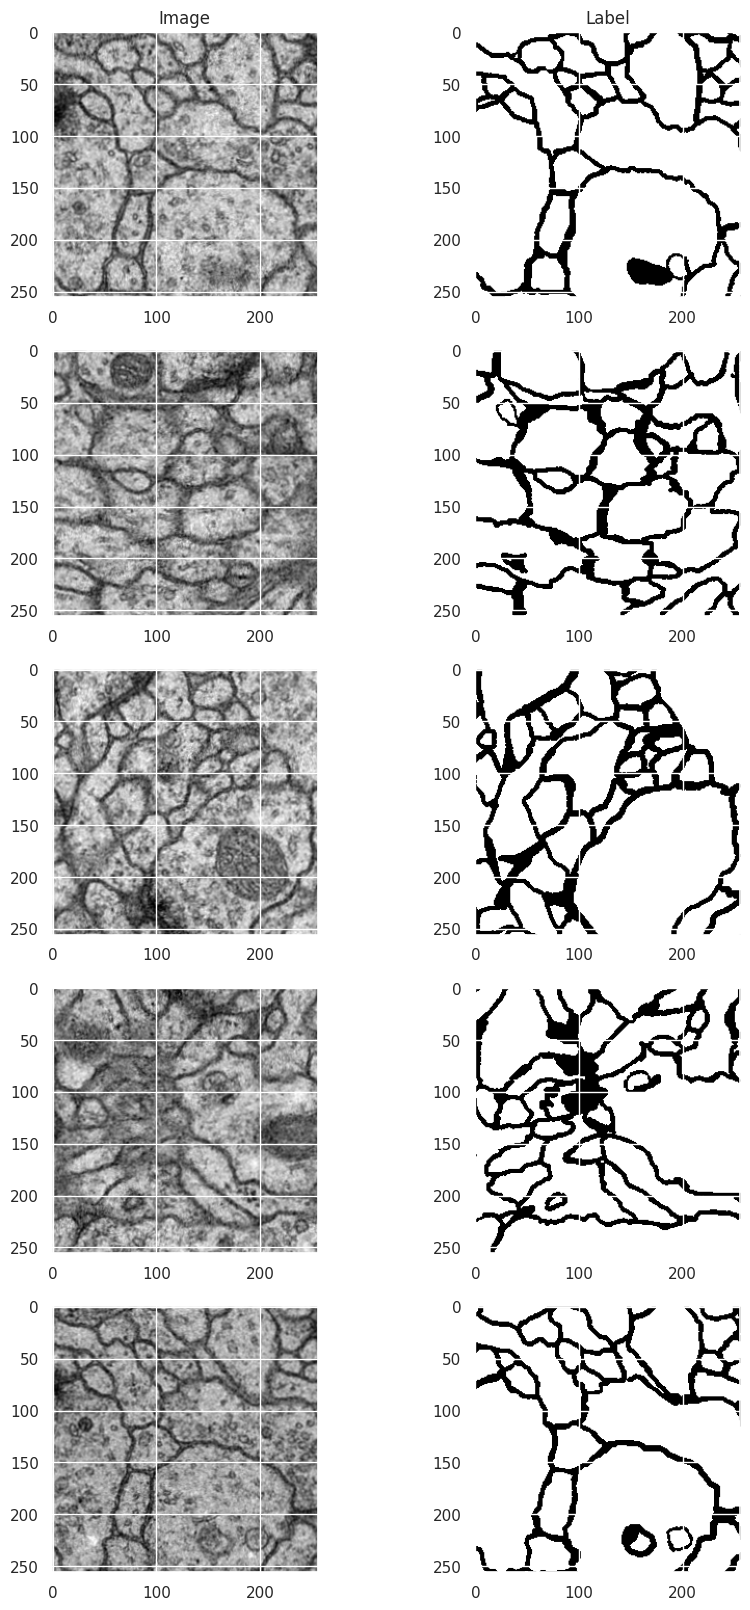

In [41]:
# Plot the first 5 images and labels in the train set
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray')

ax[0, 0].set_title('Image')
ax[0, 1].set_title('Label');

In [8]:
# Create convolutional network taking size 256x256 as input and outputting size 256x256.
# The network should have 3 convolutional layers with 3x3 kernels and 1x1 stride.
# The first two layers should have 16 output channels, the last one should have 2 output channels.
# The first two layers should have ReLU activation, the last one should have no activation.
# The network should have a final softmax layer.

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 2, 3, stride=1, padding=1)
        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return self.softmax(x)


## Improved net

In [21]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 2, 3, stride=1, padding=1)
        self.dropout = torch.nn.Dropout2d(p=0.5)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.conv4(x)
        # Resize the output to match the target size
        x = torch.nn.functional.interpolate(x, size=(256, 256), mode='bilinear', align_corners=True)
        return torch.nn.functional.softmax(x, dim=1)

## (EOF) Improved net

In [22]:
epochs = 20
loss_function = torch.nn.CrossEntropyLoss()
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epoch_train_losses = []

In [23]:
# Train the network
for e in range(epochs):
    train_losses = []
    for batch in trainloader:
        optimizer.zero_grad()
        output = net(batch[0].unsqueeze(1))
        loss = loss_function(output, batch[1])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))

    print(f'Epoch {e+1}/{epochs} | Train loss: {epoch_train_losses[-1]:.6f}')

Epoch 1/20 | Train loss: 0.526303
Epoch 2/20 | Train loss: 0.463086
Epoch 3/20 | Train loss: 0.451250
Epoch 4/20 | Train loss: 0.445338
Epoch 5/20 | Train loss: 0.441908
Epoch 6/20 | Train loss: 0.439398
Epoch 7/20 | Train loss: 0.437505
Epoch 8/20 | Train loss: 0.434347
Epoch 9/20 | Train loss: 0.431878
Epoch 10/20 | Train loss: 0.431721
Epoch 11/20 | Train loss: 0.430545
Epoch 12/20 | Train loss: 0.428717
Epoch 13/20 | Train loss: 0.428141
Epoch 14/20 | Train loss: 0.426667
Epoch 15/20 | Train loss: 0.427576
Epoch 16/20 | Train loss: 0.426024
Epoch 17/20 | Train loss: 0.424631
Epoch 18/20 | Train loss: 0.424227
Epoch 19/20 | Train loss: 0.424259
Epoch 20/20 | Train loss: 0.424311


In [24]:
# Plot the train loss
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(np.arange(1, epochs + 1, 1), epoch_train_losses)
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1, epochs + 1, 1))
ax.set_ylabel('Train Loss')
plt.show()

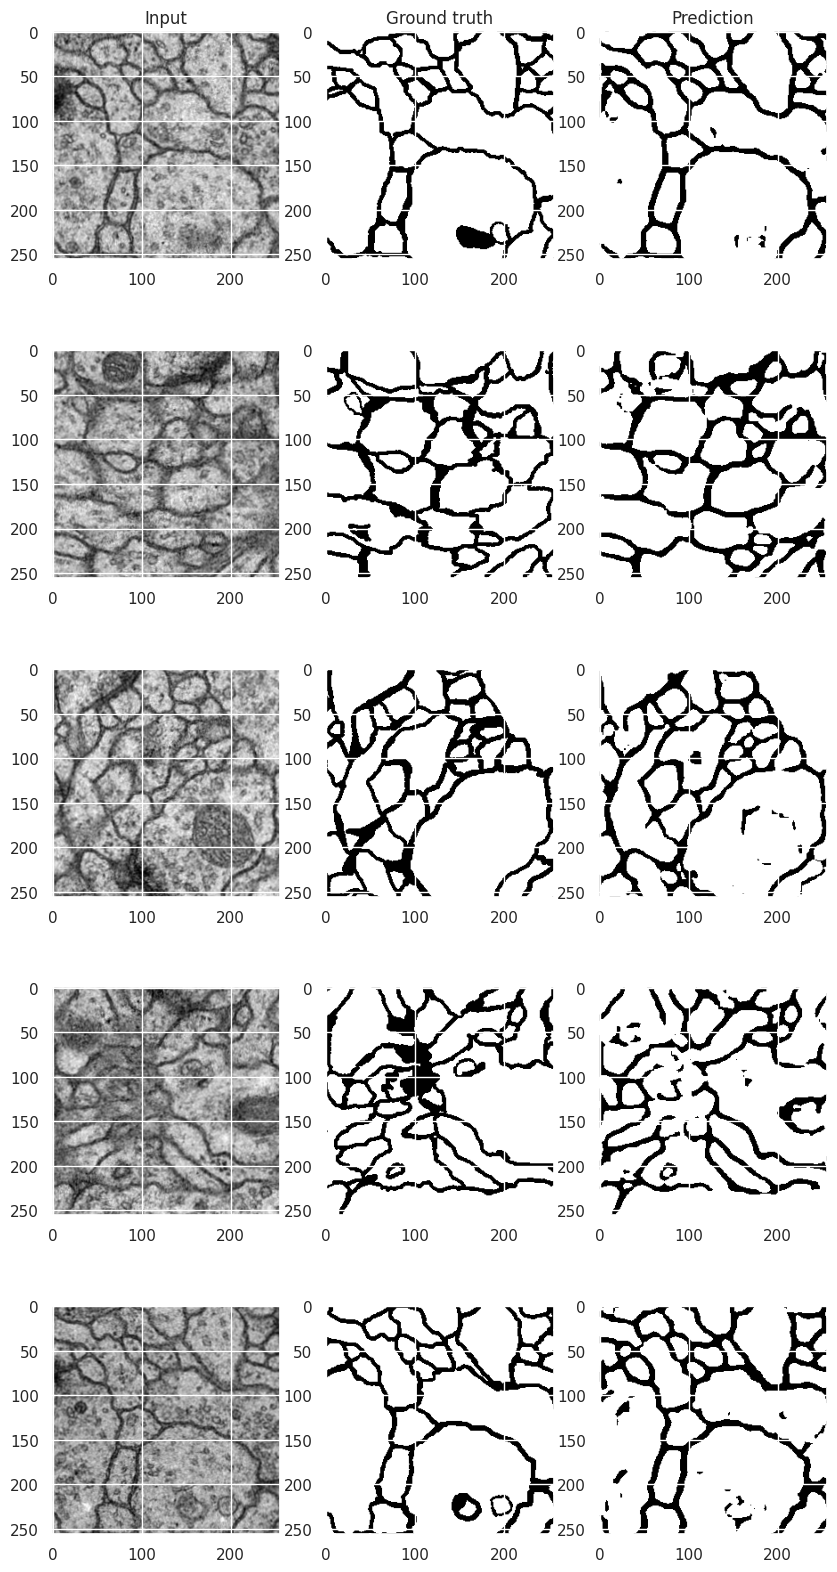

In [39]:
# Visualize train predictions
fig, ax = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray')
    ax[i, 2].imshow(torch.argmax(net(challengeTrainData[i][0].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input')
ax[0, 1].set_title('Ground truth')
ax[0, 2].set_title('Prediction');

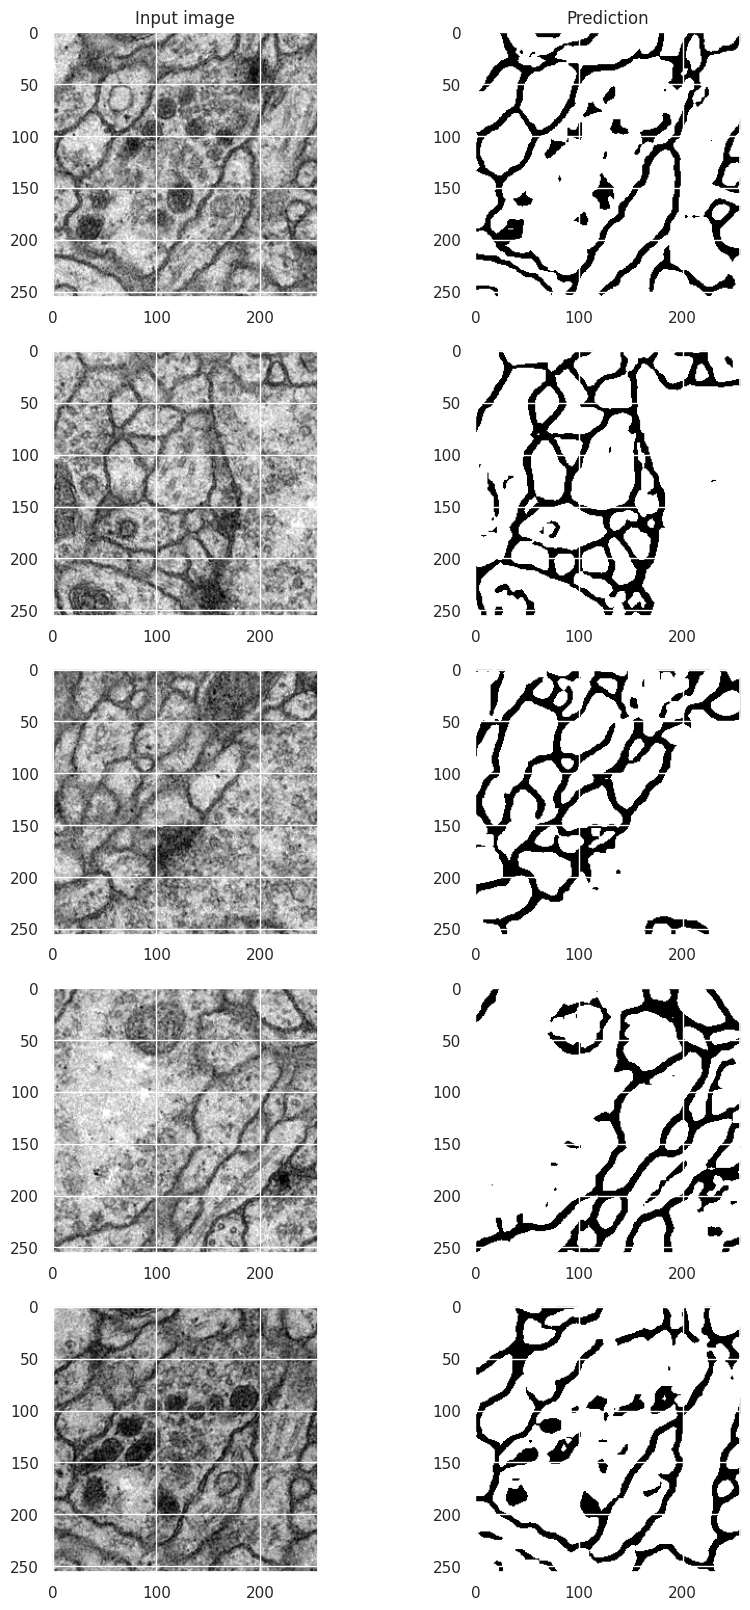

In [42]:
# Visualize test predictions
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTestData[i], cmap='gray')
    ax[i, 1].imshow(torch.argmax(net(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input image')
ax[0, 1].set_title('Prediction');

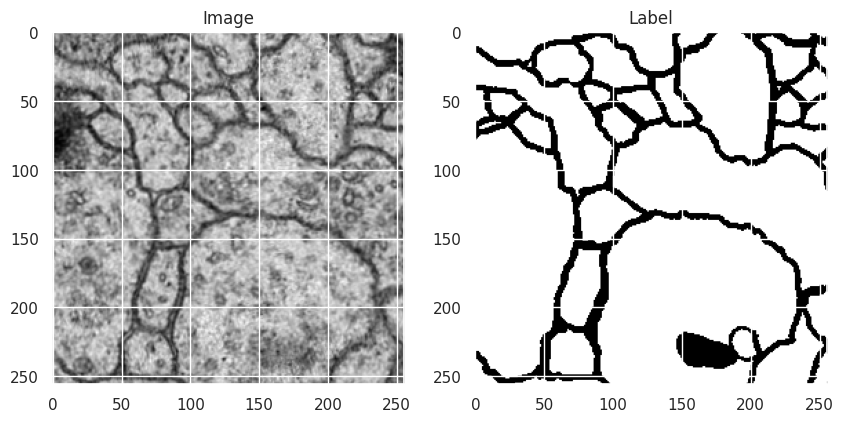

In [50]:
img = challengeTrainData[0][0]
lbl = challengeTrainData[0][1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Image')

ax[1].imshow(lbl, cmap='gray')
ax[1].set_title('Label')

plt.show()

# Data augmentation

In [28]:
from scipy.ndimage import gaussian_filter, map_coordinates

In [51]:
# Apply Random Elastic Deformation
# (This involves loading images and may take some seconds.)

def random_elastic_deformation(image, label, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    img_augmented = map_coordinates(image, indices, order=1).reshape(shape)
    lbl_augmented = map_coordinates(label, indices, order=1).reshape(shape)
    return img_augmented, lbl_augmented

In [52]:
img = challengeTrainData[0][0].numpy()
lbl = challengeTrainData[0][1].numpy()

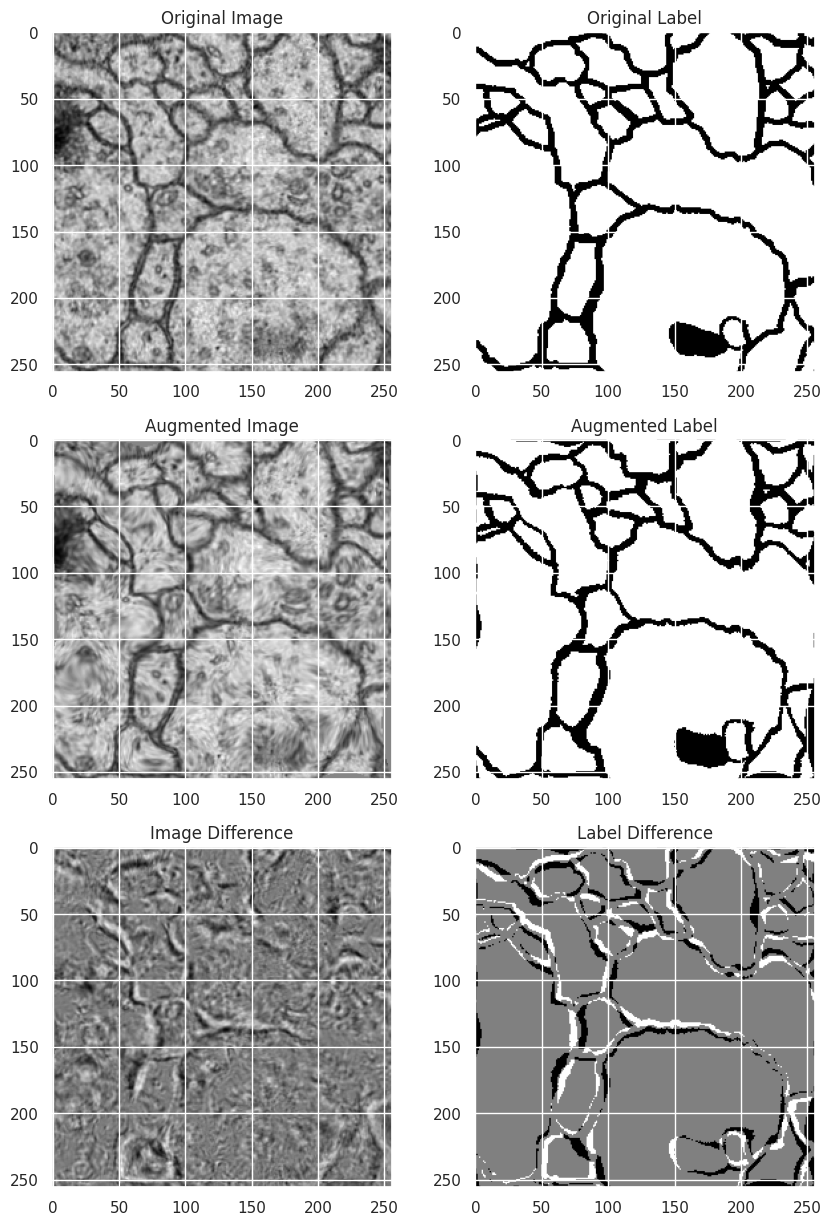

In [53]:
img_augmented, lbl_augmented = random_elastic_deformation(img, lbl, 200, 10)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

ax[0, 0].imshow(img, cmap='gray')
ax[0, 0].set_title('Original Image')

ax[0, 1].imshow(lbl, cmap='gray')
ax[0, 1].set_title('Original Label')

ax[1, 0].imshow(img_augmented, cmap='gray')
ax[1, 0].set_title('Augmented Image')

ax[1, 1].imshow(lbl_augmented, cmap='gray')
ax[1, 1].set_title('Augmented Label')

ax[2, 0].imshow(img_augmented - img, cmap='gray')
ax[2, 0].set_title('Image Difference')

ax[2, 1].imshow(lbl_augmented - lbl, cmap='gray')
ax[2, 1].set_title('Label Difference')

plt.show()

In [32]:
# Make dataset class.
class ChallengeData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, train_set, augmentations=[], margin_size=20):
        self.images = []
        self.labels = []

        self.train_set = train_set
  
        normalizer = Normalize(mean=(0.5), std=(0.5))

        img_prefix = 'train' if train_set else 'test'
        img_folder = 'train_images' if train_set else 'test_images'
        labels_folder = 'train_labels'
        labels_prefix = 'labels'

        for idx in range(1, nr_im + 1):
            im = np.array(PIL.Image.open(f'{data_dir}/{img_folder}/{img_prefix}_{idx:02d}.png'))
            # im = im/255
            im = normalizer.apply(image=im, p=1)
            im1 = im[:256,:256]
            im2 = im[256:,:256]
            im3 = im[:256,256:]
            im4 = im[256:,256:]
            
            self.images.append(torch.tensor(im1, dtype=torch.float32))
            self.images.append(torch.tensor(im2, dtype=torch.float32))
            self.images.append(torch.tensor(im3, dtype=torch.float32))
            self.images.append(torch.tensor(im4, dtype=torch.float32))
            # Divide into iamges of size 128x128

            if train_set:
                label_im = np.array(PIL.Image.open(f'{data_dir}/{labels_folder}/{labels_prefix}_{idx:02d}.png'))
                label_im = label_im/255
                # label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
                label_im1 = label_im[:256,:256]
                label_im2 = label_im[256:,:256]
                label_im3 = label_im[:256,256:]
                label_im4 = label_im[256:,256:]

                self.labels.append(torch.tensor(label_im1, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im2, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im3, dtype=torch.int64))
                self.labels.append(torch.tensor(label_im4, dtype=torch.int64))

                for i, (small_img, small_lbl) in enumerate(zip([im1, im2, im3, im4], [label_im1, label_im2, label_im3, label_im4])):
                    for alpha in augmentations:
                        img_augmented, lbl_augmented = random_elastic_deformation(small_img, small_lbl, alpha, 10)
                        self.images.append(torch.tensor(img_augmented, dtype=torch.float32))
                        self.labels.append(torch.tensor(lbl_augmented, dtype=torch.int64))
            
    def __getitem__(self, idx):
        if self.train_set:
            return self.images[idx], self.labels[idx]
        
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [33]:
# Create dataset objects.
train_data = ChallengeData(datadir, 30, True, augmentations=[20, 50, 100, 200, 500])
test_data = ChallengeData(datadir, 30, False)

# Create data loaders.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=False)

In [34]:
# Train the network on the augmented data
net_augmented = Net()

# Define a loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_augmented.parameters(), lr=0.001)

epochs = 20

epoch_losses_augmented = []

for e in range(epochs):  # loop over the dataset multiple times

    losses = []

    for batch in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_augmented(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss)

    epoch_losses_augmented.append(loss.item())

    print(f'Epoch {e+1} finished. Loss: {epoch_losses_augmented[-1]}')

Epoch 1 finished. Loss: 0.4707525372505188
Epoch 2 finished. Loss: 0.4438343048095703
Epoch 3 finished. Loss: 0.4465901851654053
Epoch 4 finished. Loss: 0.4548468589782715
Epoch 5 finished. Loss: 0.43187785148620605
Epoch 6 finished. Loss: 0.44088274240493774
Epoch 7 finished. Loss: 0.43100517988204956
Epoch 8 finished. Loss: 0.4415784478187561
Epoch 9 finished. Loss: 0.4364713132381439
Epoch 10 finished. Loss: 0.422684907913208
Epoch 11 finished. Loss: 0.43067923188209534
Epoch 12 finished. Loss: 0.4297073781490326
Epoch 13 finished. Loss: 0.4240242838859558
Epoch 14 finished. Loss: 0.42426928877830505
Epoch 15 finished. Loss: 0.44941622018814087
Epoch 16 finished. Loss: 0.43092775344848633
Epoch 17 finished. Loss: 0.4362507462501526
Epoch 18 finished. Loss: 0.43150633573532104
Epoch 19 finished. Loss: 0.4247759282588959
Epoch 20 finished. Loss: 0.4242437481880188


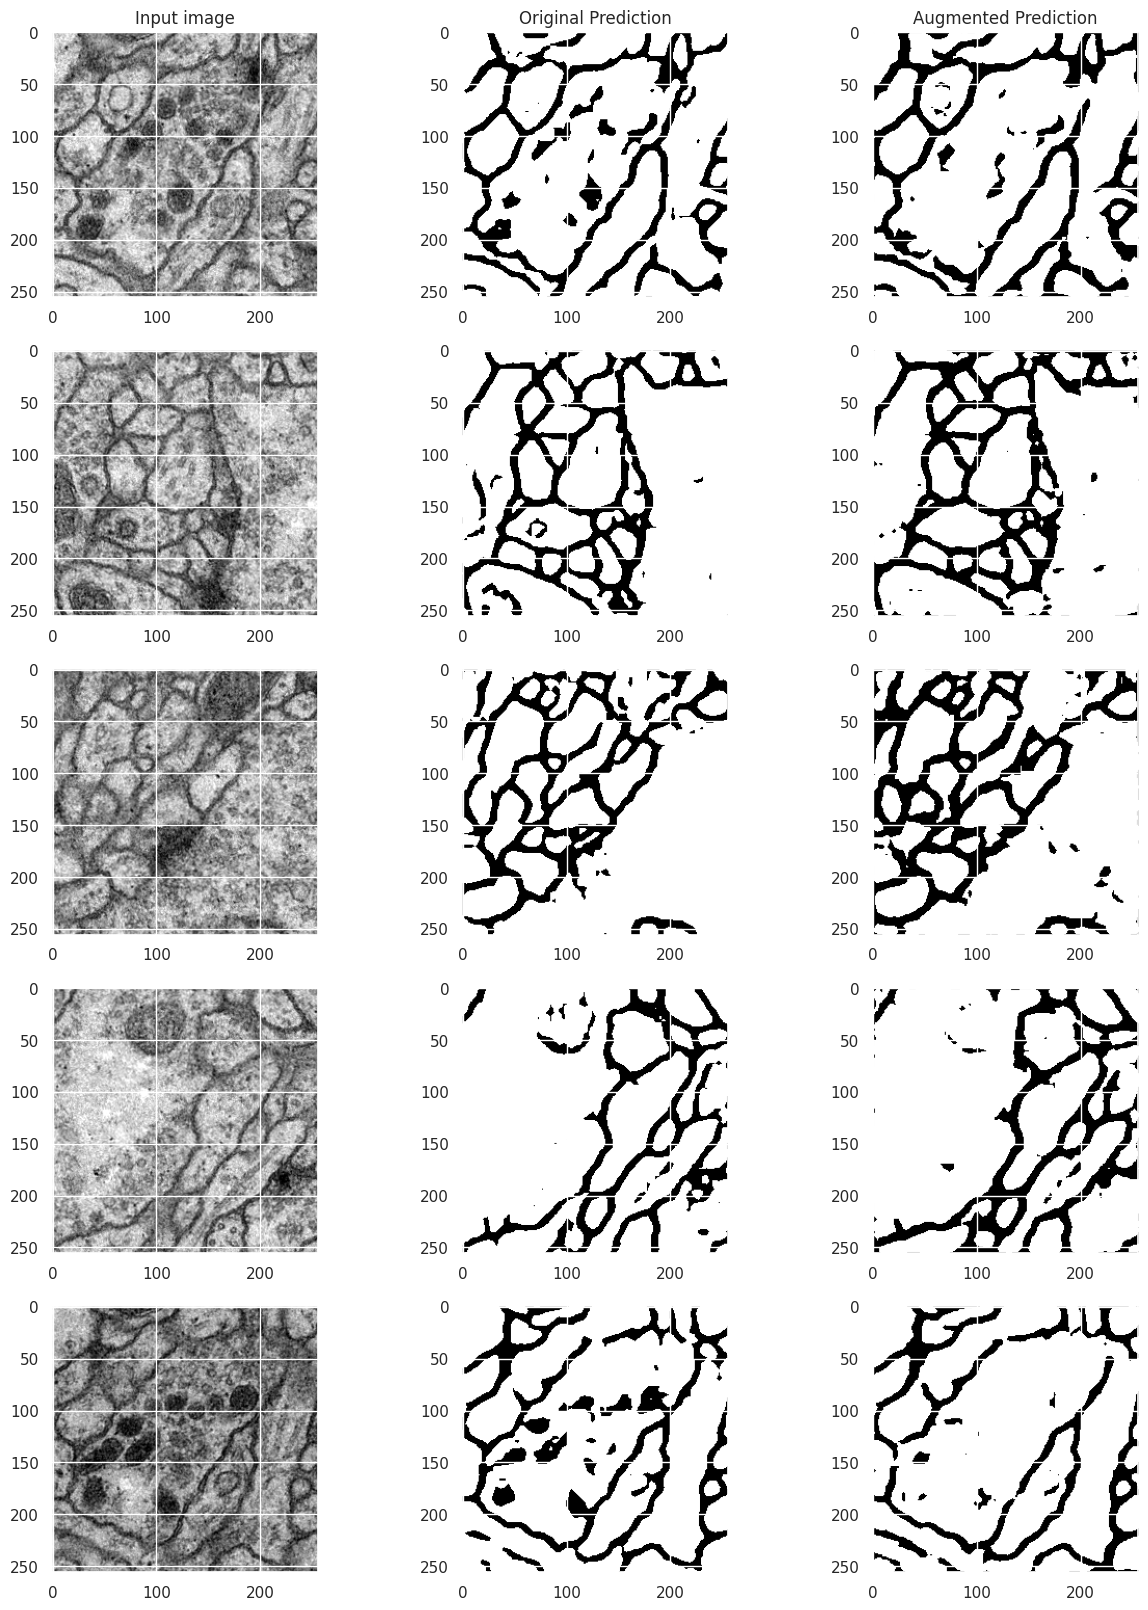

In [55]:
# Visualize test predictions
fig, ax = plt.subplots(5, 3, figsize=(15, 20))

for i in range(5):
    ax[i, 0].imshow(challengeTestData[i], cmap='gray')
    ax[i, 1].imshow(torch.argmax(net(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')
    ax[i, 2].imshow(torch.argmax(net_augmented(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray')

ax[0, 0].set_title('Input image')
ax[0, 1].set_title('Original Prediction')
ax[0, 2].set_title('Augmented Prediction')

plt.show()